# ERCOT Load Model

*Adapted from Dr. David Chassin's Aggregate Building Load Model*

Olin Shipstead

## Importing data

In [1]:
from datetime import *
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re

,Load
timestamp,
2021-01-01 00:00:00,3545.093310
2021-01-01 01:00:00,3586.547882
2021-01-01 02:00:00,3586.124059
2021-01-01 03:00:00,3570.592369
2021-01-01 04:00:00,3590.902242


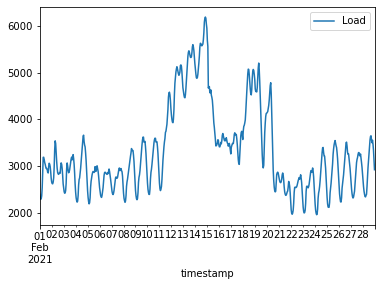

In [2]:
# ------ IMPORTING LOAD DATA --------- #
# Source: http://www.ercot.com/gridinfo/load/load_hist
# using ERCOT's Southern Load Zone

def fix_time(x):
    m, d, y, h, mn = map(int, re.findall('\d+', str(x["Hour Ending"])))
    return datetime(y,m,d,h-1,mn)

load = pd.read_excel("ERCOT_Native_Load_2021.xlsx")

load["timestamp"] = load.apply(fix_time, axis=1)
load = load.filter(["timestamp","SOUTH"]).rename(columns={"SOUTH":"Load"}).set_index("timestamp") # focusing on SOUTH as this is where we have solar data
load["2021-02-01":"2021-02-28"].plot();
load.head()

#! find out what caused lout drops on 19th and 20th

,Solar,Temp
2021-02-08 17:00:00,197.9478,26.6153
2021-02-08 18:00:00,58.8003,26.2997
2021-02-08 19:00:00,3.9165,25.4203
2021-02-08 20:00:00,0.0000,23.6561
2021-02-08 21:00:00,0.0000,23.1087


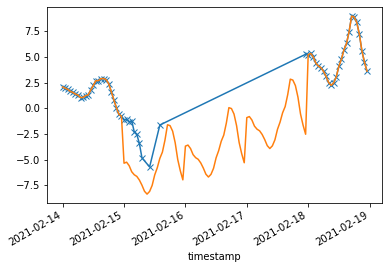

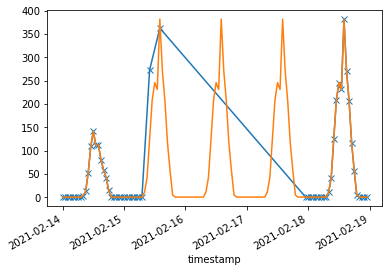

In [3]:
# ------ IMPORTING SOLAR+TEMP DATA ------ #
# Source: University of Texas Panamerican Solar Radiation Lab (https://midcdmz.nrel.gov/apps/daily.pl?site=UTPASRL&start=20110901&yr=2021&mo=11&dy=15)
# solar data is complete, but temp data only goes back to 02/08/2021
#! note - weather data complete from 02/08/2021 to mid-May 2021

weather = pd.read_csv("UT-PanAmerican_Solar_Temp.txt",sep=",", na_values=-99999).dropna()
weather["timestamp"] = weather.apply(lambda x: datetime.strptime(str(x["DATE (MM/DD/YYYY)"])+" "+str(x["HOUR-CST"]),"%m/%d/%Y %H"), axis=1)
weather = weather.filter(["timestamp","Avg Global Horizontal [W/m^2]","Avg Air Temperature [deg C]"])\
    .rename(columns={"Avg Global Horizontal [W/m^2]":"Solar","Avg Air Temperature [deg C]":"Temp"})\
    .set_index("timestamp")

weather["Solar"] = weather.apply(lambda x: 0 if x["Solar"]<0 else x["Solar"], axis=1) # clip solar at 0

plt.figure(1)
weather.Temp["2021-02-14":"2021-02-18"].plot(marker="x")
plt.figure(2)
weather.Solar["2021-02-14":"2021-02-18"].plot(marker="x")

daily_means = (np.array([22, 25, 30]) - 32)*5/9 #  daily means taken from NOAA
def impute_dates(x, date_to_copy):
    l = list(x["2021-02-15"].index)+list(x["2021-02-17"].index) # delete existing values for 02-15 and 02-17
    x = x.drop(l)
    
    # 15th
    temp = pd.DataFrame(weather[date_to_copy])
    temp["Temp"] = temp.Temp.values - np.mean(temp.Temp) + daily_means[0]
    temp.index = pd.date_range("2021-02-15", periods=24, freq="H") # create new date_times
    x = x.append(temp, verify_integrity=True)
  
    # 16th
    temp = pd.DataFrame(weather[date_to_copy])
    temp["Temp"] = temp.Temp.values - np.mean(temp.Temp) + daily_means[1]
    temp.index = pd.date_range("2021-02-16", periods=24, freq="H") # create new date_times
    x = x.append(temp, verify_integrity=True)
    
    # 17th
    temp = pd.DataFrame(weather[date_to_copy])
    temp["Temp"] = temp.Temp.values - np.mean(temp.Temp) + daily_means[2]
    temp.index = pd.date_range("2021-02-17", periods=24, freq="H") # create new date_times
    x = x.append(temp, verify_integrity=True)
    return x.sort_index()

weather = impute_dates(weather, "2021-02-18")
plt.figure(1)
weather.Temp["2021-02-14":"2021-02-18"].plot();
plt.figure(2)
weather.Solar["2021-02-14":"2021-02-18"].plot();
weather.head()

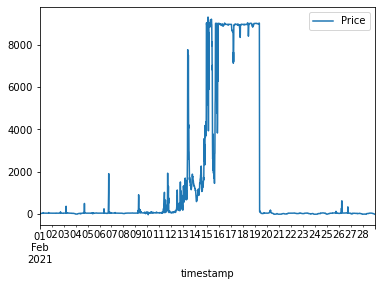

In [4]:
# ------ IMPORTING PRICE DATA ------ #
# Source: https://sa.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey
# data represents Historical RTM Load Zone and Hub Prices

price = pd.read_excel("Feb21_LZ_SOUTH_Prices.xlsx", sheet_name="Feb")

price["timestamp"] = price.apply(lambda x: datetime.strptime(\
                                        str(x["Delivery Date"])+" "+\
                                        str(x["Delivery Hour"]-1)+":"+\
                                        str((x["Delivery Interval"]-1)*15),\
                                       "%m/%d/%Y %H:%M"),\
                                        axis=1)
price = price.filter(["timestamp","Settlement Point Price"])\
    .rename(columns={"Settlement Point Price":"Price"}).set_index("timestamp")
price["2021-02-01":"2021-02-28"].plot();
price.head();

## Merging and interpolating data to hourly data

In [5]:
start = "2021-02-08 17:00:00" # constrained by weather (solar)
end = "2021-02-28 23:00:00"   # constrained by price
load_df = price.join(weather).join(load)[start:end].dropna()#.interpolate(method="slinear") # interpolates solar, temp, load

#! load_df group_by hourly to find hourly mean price?

load_df["Weekend"]=np.matrix(np.floor(load_df.index.weekday/5)).T

print(f"Number of observations: {len(load_df)}")
load_df.head()

#! step back to hourly data?
# interpolation filter seems to affect model
# interpolation adds information/signal to system that is not originally there?

# if we use an interpolator, make sure to clip solar

# "model predictive control" theory, used for control systems, not so much for market mechanisms 

Number of observations: 480


,Price,Solar,Temp,Load,Weekend
timestamp,,,,,
2021-02-08 17:00:00,20.25,197.9478,26.6153,3340.425916,0.0
2021-02-08 18:00:00,27.69,58.8003,26.2997,3333.608096,0.0
2021-02-08 19:00:00,23.30,3.9165,25.4203,3333.742390,0.0
2021-02-08 20:00:00,20.97,0.0000,23.6561,3232.529173,0.0
2021-02-08 21:00:00,20.74,0.0000,23.1087,3096.684786,0.0


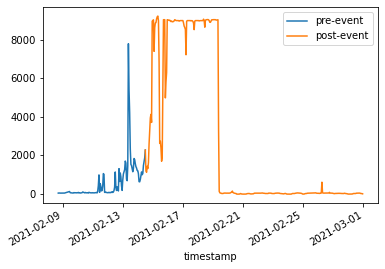

In [6]:
# define event timestamp to be midday 02-14
event = "02-14-2021 12:00:00"
load_df.Price[:event].plot(label="pre-event",legend=True)
load_df.Price[event:].plot(label="post-event",legend=True);

<AxesSubplot:xlabel='timestamp'>

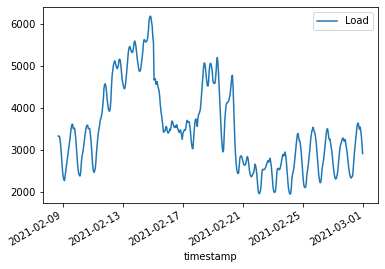

In [7]:
load_df.plot(y="Load")

## Define transfer function

The $z$-domain transfer function from $T_O$ to $L$ can be written as
$$
    { L(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{L}_{t} = 
        + b_2 \mathbf{T}_{t-2} 
        + b_1 \mathbf{T}_{t-1} 
        + b_0 \mathbf{T}_{t} 
        - a_3 \mathbf{L}_{t-3} 
        - a_2 \mathbf{L}_{t-2} 
        - a_1 \mathbf{L}_{t-1}
$$
where $t \in (4,K)$, and $\mathbf L$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, this can be written in the form
$$
    \mathbf{M} \mathbf{x} = \mathbf{L}_{t}
$$
where $\mathbf{M} \in \mathbb{R}^{K-3\times12}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{L}_{t-3} & \mathbf{L}_{t-2} & \mathbf{L}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} b_2 & b_1 & b_0 & -a_2 & -a_1 & -a_0 \end{matrix} \right]^T
$$
Solve for $\mathbf x$.
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{L}_{t}.
$$

This solution can also be obtained efficiently using the Python SciPy `linalg.solve` function.


$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{L}_{t-3} & \mathbf{L}_{t-2} & \mathbf{L}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} & \mathbf{S}_{t-2} & \mathbf{S}_{t-1} & \mathbf{S}_{t} & \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{P}_{t}\end{matrix} \right]
$$

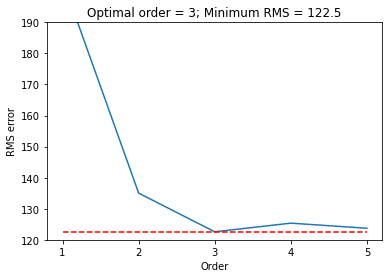

In [64]:
# testing order
order_dict = {}
for R in range(1,6):
    K = len(load_df.Price) # num observations
    N = len(load_df.Price[event:]) # observations to hold out

    L = np.matrix(load_df.Load).transpose()  # load
    T = np.matrix(load_df.Temp).transpose()  # temp
    S = np.matrix(load_df.Solar).transpose() # solar
    P = np.matrix(load_df.Price).transpose() # price

    # construct M matrix
    M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
                np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
                np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
                np.hstack([P[n+1:K-R+n+1] for n in range(R)])])

    Mh = M[0:-N] # leaving out last N observations
    Mt = Mh.transpose()
    x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))
    Q = np.matmul(M[-N:],x) # predicted power output
    
    # store MSEs in dict
    order_dict[R] = np.mean(np.square(Q[-N:]-L[-N:])) # double check

rms = np.array(list(order_dict.values()))**0.5
plt.plot(list(order_dict.keys()),rms)
plt.xlabel("Order")
plt.xticks(range(1,6))
plt.ylabel("RMS error")
plt.plot(range(1,6),[min(rms)]*5,'r--')
plt.ylim([120,190])
plt.title("Optimal order = "+str(min(order_dict, key=order_dict.get))+"; Minimum RMS = "+str(min(rms))[:5]);

In [9]:
order_dict[3]**0.5

122.57419576289314

## Solve for transfer function coefficients

In [106]:
start = datetime.now()
R = min(order_dict, key=order_dict.get) # order of model = 
K = len(load_df.Price) # num observations
N = len(load_df.Price[event:]) # observations to hold out
print(N)
print(len(load_df.Price[:event])-1)

L = np.matrix(load_df.Load).transpose()  # load
T = np.matrix(load_df.Temp).transpose()  # temp
S = np.matrix(load_df.Solar).transpose() # solar
P = np.matrix(load_df.Price).transpose() # price
W = np.matrix(load_df.Weekend).transpose() # weekend indicator

# construct M matrix
M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
            np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([P[n+1:K-R+n+1] for n in range(R)])])
#            np.hstack([W[n+1:K-R+n+1] for n in range(R)])])
print(M.shape)

Mh = M[0:-N] # leaving out last N observations
Mt = Mh.transpose()
x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))
Q = M[-N:]*x # predicted power output
print(Q.shape)
end = datetime.now()
print(str(end-start))

348
132
(477, 12)
(348, 1)
0:00:00.007971


In [105]:
np.set_printoptions(precision=4, suppress=True)
print(x.T)

[[ 0.0993 -0.8372  1.7398 -6.1188 12.3925 -7.2068  0.7965 -1.8521  1.2089
  -0.003  -0.0168  0.0132]]


  $$
    \mathbf{x} = \left[ \begin{matrix} 0.0993 & -0.8372 & 1.7398 & -6.1188 & 12.3925 & -7.2068 & 0.7965 & -1.8521 & 1.2089 & -0.003 & -0.0168 & 0.0132\end{matrix} \right]
$$

In [109]:
# Calc MSE
print("MSE:",np.mean(np.square(Q[-N:]-L[-N:])))

# initial model: load, temp, solar, price; order=3 -> 15024.43346692005
# weekend flag:  load, temp, solar, price, weekend; order=3 -> 18988.434477662817

MSE: 15024.43346692005


## Visualize results

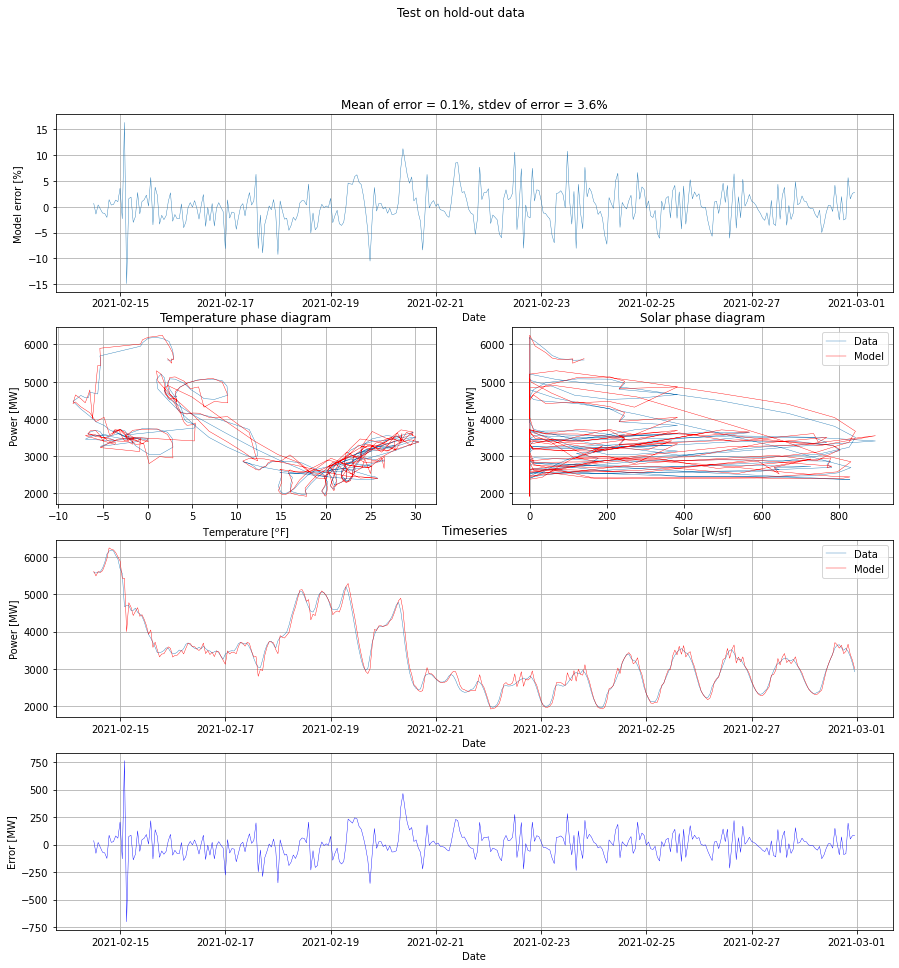

In [12]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(411)
e = Q/L[-N:]-1 
t = load_df.index
plt.plot(t[-N:],e*100,linewidth=0.4)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(423)
plt.plot(T[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(424)
plt.plot(S[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(413)
plt.plot(t[-N:],L[-N:],linewidth=0.4,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

plt.subplot(414)
plt.plot(t[-N:],Q[-N:] - L[-N:],"-b",linewidth=0.4)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Error [MW]');

<AxesSubplot:xlabel='timestamp'>

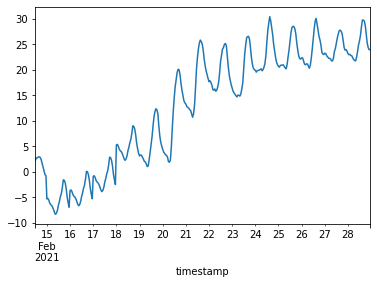

In [13]:
load_df["Temp"][event:].plot()

## Battery optimization

- battery storage = 5 kWh and battery power = 1 kW
- inter-temporal battery efficiency = 100%
- the round-trip efficiency = 95% (on charging)  
- minimum charge = 1kWh (20%)
- market runs per hour = 1 [hr^-1]

In [14]:
import cvxpy as cp

In [15]:
# Initialize variables
s = cp.Variable((K+1,)) # state of charge (kWh)
x_d = cp.Variable((K,)) # discharging dispatches (kW)
x_c = cp.Variable((K,)) # charging dispatches (kW)

# Initialize constraints
constraints = [s[0]==2.]
constraints += [s[K]==2.]

# Append physical constraints for all t
for t in range(K):
    constraints += [x_d[t]<=1., x_d[t]>=0.,
                    x_c[t]<=1., x_c[t]>=0.,
                    s[t]>=1., s[t]<=5., 
                    s[t+1]==1.00*s[t] + 0.95*x_c[t]/1 - x_d[t]/1 ] # kWh = kWh + kW/(1/hr) - kW/(1/hr)
    
# Objective function
obj = cp.Maximize(cp.sum(cp.multiply(load_df.Price/1000,(x_d-x_c)/1))) # $/kWh * (kW-kW)/(1/hr) = $/kWh * kWh = $

In [16]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = prob.solve()

In [17]:
print("Optimal profits: ${0:.2f}".format(profits))

Optimal profits: $106.63


## Visualization

Text(0.5, 1.0, 'Hourly profit time series')

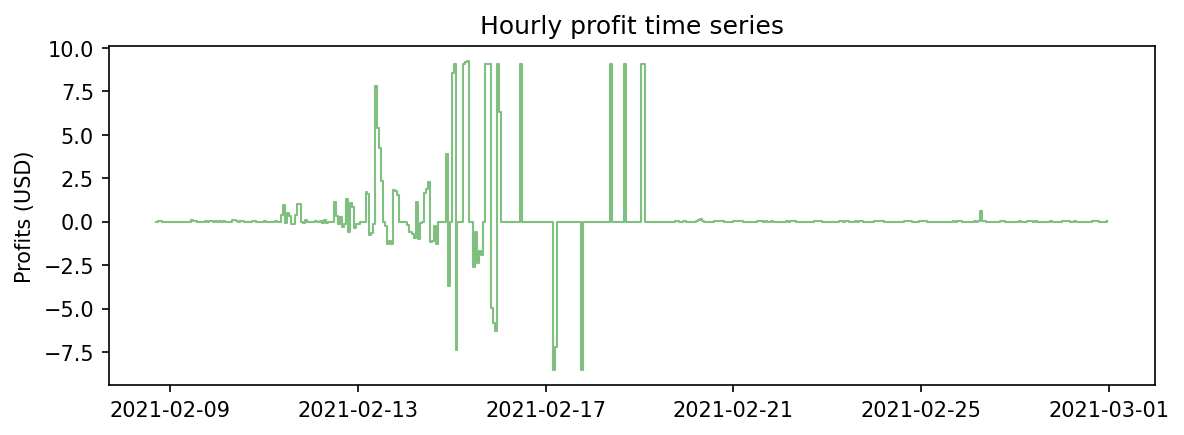

In [111]:
fig = plt.figure(figsize=(9,3),dpi=150) 

# ax = fig.add_subplot(211)
# ax.step(load_df.index, load_df.Price, alpha=0.5, linewidth=1, where="post", color='blue', label='RT')
# ax.set_ylabel('Price ($/MWh)')
# plt.title("Price and profit time series");

ax2 = fig.add_subplot(111)
hrly_profit = -(x_c.value-x_d.value)*load_df.Price/1000/1
#ax2.step(load_df.index, np.cumsum(hrly_profit)/profits, alpha=0.5, linewidth=1, where="post", color='green', label='Profits')
ax2.step(load_df.index, hrly_profit, alpha=0.5, linewidth=1, where="post", color='green', label='Profits')

ax2.set_ylabel("Profits (USD)");
plt.title("Hourly profit time series");

#! upload updated notebook to GitHub

#! next step: match battery to power data
# create counterfactual: if batteries were operating on 15th, what effect would that have had on the system
# want to avoid freq drop, use price as a proxy?
# want to avoid forced outage... how many batteries to avoid this?

# what is the smallest # of batteries that have an effect on the load forecast?
# can we determine the magnitude of battery resources that could have attenuated the event

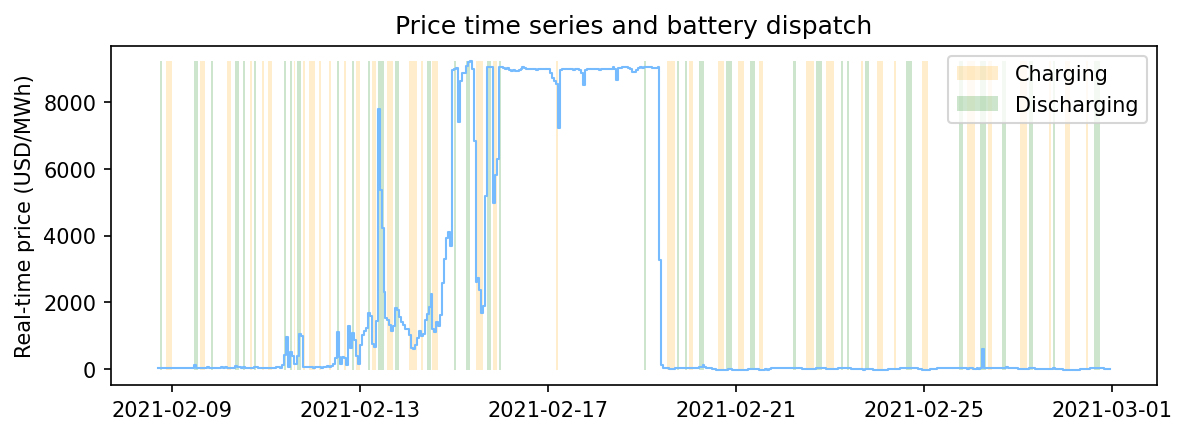

In [112]:
results_df = pd.DataFrame({"s":s[:-1].value,"P_t":load_df.Price,"x_c":x_c.value,"x_d":x_d.value})
day = results_df

plt.figure(figsize=(9,3),dpi=150)
plt.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_c"]>0.001)&(day["x_d"]<0.001), facecolor='orange', alpha=0.2,label="Charging")
plt.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_d"]>0.001)&(day["x_c"]<0.001), facecolor='green', alpha=0.2, label="Discharging")
plt.step(day.index, day["P_t"], linewidth=1, where="post", color='xkcd:sky blue');
plt.ylabel('Real-time price (USD/MWh)')
plt.legend();
plt.title("Price time series and battery dispatch");

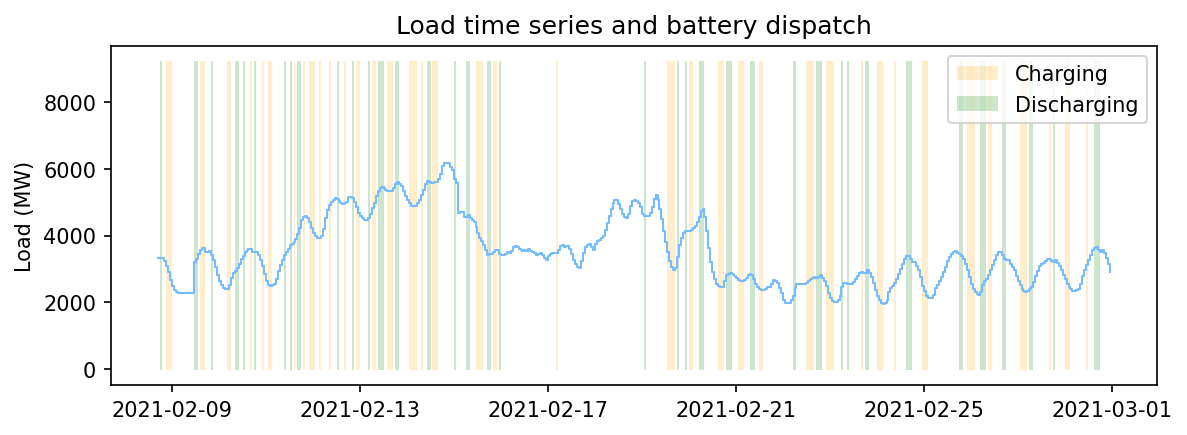

In [20]:
results_df = pd.DataFrame({"s":s[:-1].value,"P_t":load_df.Price,"x_c":x_c.value,"x_d":x_d.value})
day = results_df

plt.figure(figsize=(9,3),dpi=150)
plt.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_c"]>0.001)&(day["x_d"]<0.001), facecolor='orange', alpha=0.2,label="Charging")
plt.fill_between(day.index,max(day["P_t"]), min(day["P_t"]), where = (day["x_d"]>0.001)&(day["x_c"]<0.001), facecolor='green', alpha=0.2, label="Discharging")
plt.step(load_df.index, load_df.Load, linewidth=1, where="post", color='xkcd:sky blue');
plt.legend();
plt.ylabel("Load (MW)")
plt.title("Load time series and battery dispatch");

# overlay actual power data L
# want to connect the battery activity to overall load

## Update load and test model

In [21]:
num_batteries = 10000
load_df["UpdatedLoad"] = load_df.Load + (x_c.value-x_d.value)/1000 * num_batteries # x_c-x_d capped at 1 kW
max((x_c.value-x_d.value)/1000 * num_batteries) # max effect=10MW

9.999999999969098

In [22]:
L = np.matrix(load_df.UpdatedLoad).transpose()  # updated load

# construct M matrix
M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
            np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([P[n+1:K-R+n+1] for n in range(R)])])

#! start with initial x's (assume it doesn't) 
#!     AKA not a substantial change in behavior
#!     10,000 batteries ~= 0.5% of homes have a change in behavior

#! then we can assume that it does --> what is that difference?

Q = M[-N:]*x # predicted power output

# Calc MSE
print("MSE (same model):",np.mean(np.square(Q[-N:]-L[-N:]))) 

#! MSE decreases... this may be significant

MSE (same model): 14959.452470415437


In [23]:
# L = np.matrix(load_df.UpdatedLoad).transpose()  # updated load

# # construct M matrix
# M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
#             np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
#             np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
#             np.hstack([P[n+1:K-R+n+1] for n in range(R)])])

# Mh = M[0:-N] # leaving out last N observations
# Mt = Mh.transpose()
# x_prime = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))

# Q_prime = M[-N:]*x_prime # predicted power output

# # Calc MSE
# print("MSE (new model):",np.mean(np.square(Q_prime[-N:]-L[-N:])))

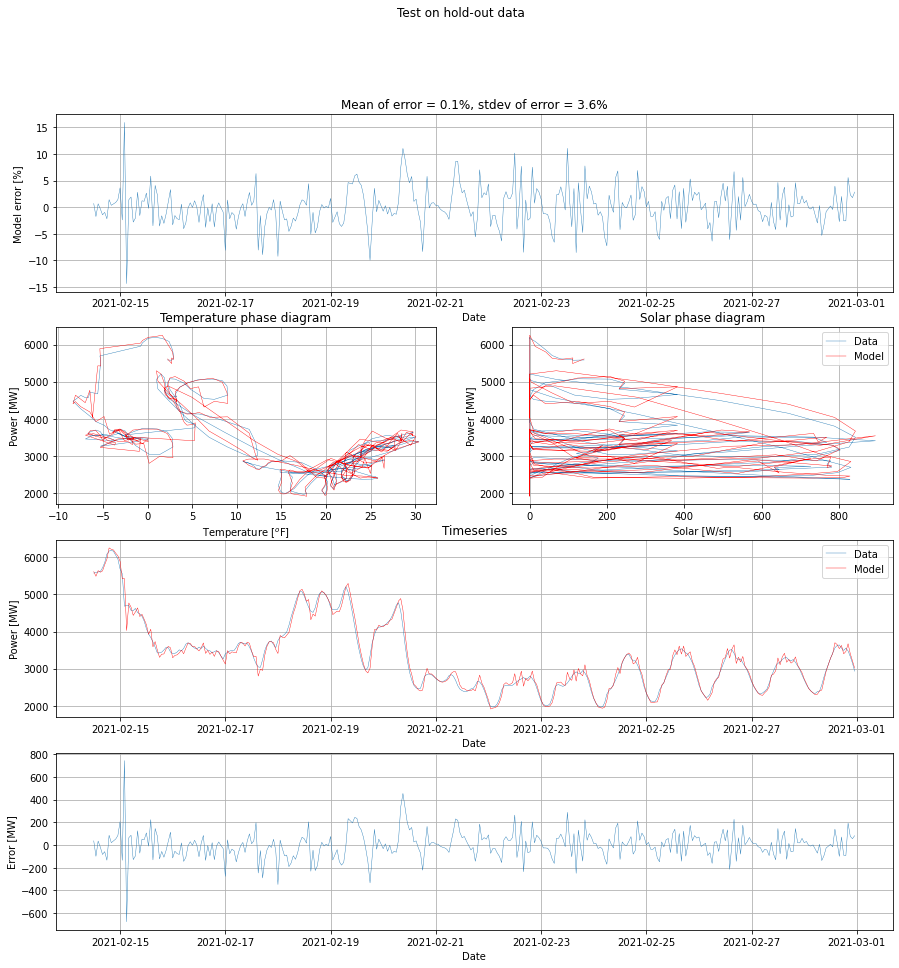

In [24]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(411)
e = Q/L[-N:]-1 
t = load_df.index
plt.plot(t[-N:],e*100,linewidth=0.4) # errors are tiny...
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(423)
plt.plot(T[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(424)
plt.plot(S[-N:],load_df.Load[-N:],linewidth=0.4,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(413)
plt.plot(t[-N:],L[-N:],linewidth=0.4,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.4,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

plt.subplot(414)
plt.plot(t[-N:],Q[-N:] - L[-N:],linewidth=0.4)
plt.grid()
plt.xlabel('Date')
plt.ylabel('Error [MW]');

Text(0.5, 0, 'Date')

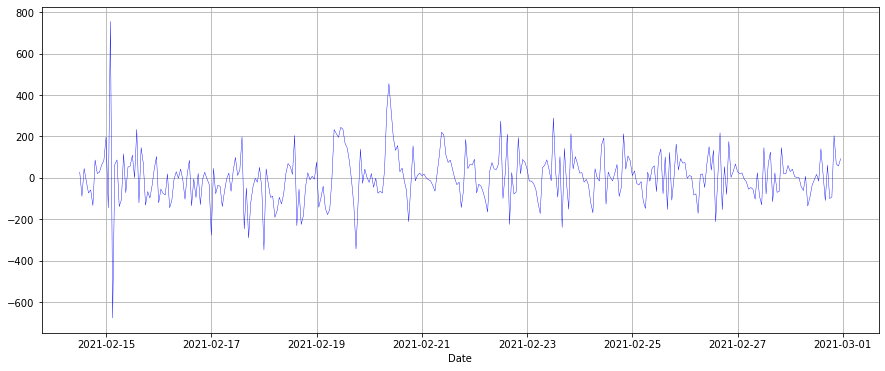

In [25]:
# predicted power with batteries - actual load w/o batteries
plt.figure(1,figsize=(15,6))
L = np.matrix(load_df.Load).transpose()
plt.plot(t[-N:],Q[-N:]-L[-N:],"-b",linewidth=0.4)
plt.grid()
plt.xlabel('Date')

----

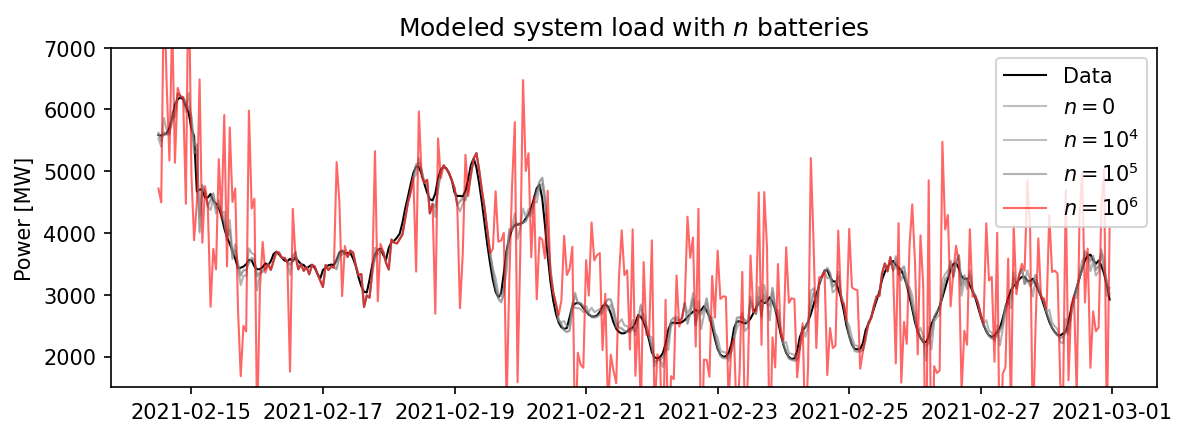

In [26]:
plt.figure(figsize=(9,3),dpi=150)
for num_batteries in [0,10**4,10**5,10**6]:
    L = np.matrix(load_df.Load + (x_c.value-x_d.value)/1000 * num_batteries).T

    # construct M matrix
    M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
                np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
                np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
                np.hstack([P[n+1:K-R+n+1] for n in range(R)])])

    Q = M[-N:]*x # predicted power output
    
    if num_batteries==0:
        plt.plot(t[-N:],load_df.Load[-N:],"-",color="black",linewidth=1,alpha=1,label="Data")
        plt.plot(t[-N:],Q[-N:],color="gray",linewidth=1,alpha=0.5,label="$n=0$")
    elif num_batteries==10**4:
        plt.plot(t[-N:],Q,"gray",linewidth=1,alpha=0.5,label="$n=10^4$")
    elif num_batteries==10**5:
        plt.plot(t[-N:],Q,"gray",linewidth=1,alpha=0.6,label="$n=10^5$")
    else:
        plt.plot(t[-N:],Q,"red",linewidth=1,alpha=0.6,label="$n=10^6$")
    plt.xlabel(None)
    plt.ylabel('Power [MW]')
    plt.ylim([1500,7000])
    plt.legend(loc="upper right")
    plt.title("Modeled system load with $n$ batteries");

---

In [27]:
def forecast(model,data,start,n,K):
    """Generate a forecast using a fitted model
    
    The model must be generated from `fit_tf`.  The
    future conditions can be taken from the historical
    data or constructed from new data using `fit_tf`.
    
    ARGUMENTS
    
        model (list)   Model return
        
        data (matrix)  Historical data
        
        start (int)    Index of starting point in data
        
        n (int)        Number of steps in data to forecast
        
        K (int)        Model order
    
    RETURNS
    
        forecast (list)   Forecast values
    """
    M = data.copy() # M matrix
    P = [M[start,K-1]]
    y = None
    for t in range(start,start+n):
        if y != None:
            M[t,0:K-1] = M[t-1,1:K]
            M[t,K-1] = y
        y = float((M[t]*model).round(1))
        P.append(y)    
    return P


In [28]:
#! how to use forecast?
forecast(model=x, data=M[:-N], start=0, n=1, K=2)

[2333.6080983183215, 2647.5]

In [29]:
# 